### Import libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import sys
sys.path.insert(0, '../scripts')
from utils import load_data, add_significance_bracket, get_all_interactions, bootstrap_by_agreement_and_group
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

### Read the data

In [10]:
fp = "../data/DANTE_Pilot_October 13, 2025_21.48.csv"
df = pd.read_csv(fp)
df = df.drop(index=[0,1])

get_all_interactions(df)

# remove internal test cases
df = df[df['participantId'] != ""]

# remove unfinished cases
df = df[df['Finished']=="True"]

# remove cases with no summary
df = df.dropna(subset=['summary', 'llm_response_1'])

# remove certain participants (HTTP and DOM errors with erroneous interactions)
error = ["6B5DC61D3F1A4FD59884E09A7390D115", "9C157F56FEEC4F22BAFEEC11763B9759", "F6586134F687435A9064E1C721EBC99F", "AF09ECC56B13406EAA4D174850B78291", "F28F21C7F66946B785FCCA3E4AEB26B2"]
duplicate_ip = ['3E8D695768544BFAAB256B25B286BE36', '2C25201441924CD69CFB850F9E0C25B7', 'ADE33812DFEE4679855302BB37ABFF84']
dnf = ['498B2C7CFDC6421A8DE46C96D56EFBB2', '57A3377A53CD49C3A03640AC86E08698', '6AEA21E0CC19480D95EF78972E41A441']
df = df[df['participantId'].apply(lambda x: x not in error+duplicate_ip+dnf)]

### Mark as agreement or disagreement treatment & ingroup or outgroup treatment

In [12]:
# Agree vs Disagree
df['agree_disagree'] = "Agree"
df.loc[df['treatment'].apply(lambda x: "Disagree" in x), 'agree_disagree'] = "Disagree"

# Ingroup vs Outgroup
df['ingroup_outgroup'] = "Ingroup"
df.loc[df['treatment'].apply(lambda x: "Outgroup" in x), 'ingroup_outgroup'] = "Outgroup"

In [13]:
# Convo satisfaction to numeric
str_to_num = {"Strongly disagree": 1, "Somewhat disagree": 2, "Neither agree nor disagree": 3, "Somewhat agree": 4, "Strongly agree": 5}

for col in ['satis1', 'satis2']:
    df[col] = df[col].map(str_to_num)

# Treatment labels to more readable format
df['treatment'] = df['treatment'].apply(lambda x: f"{x.split('_')[0].capitalize()} {x.split('_')[1].capitalize()}")

# Average satisfaction
df['satis_avg'] = (df['satis1'] + df['satis2']) / 2

/var/folders/ww/0lc4938j2439ctq3dz44v_0r0000gv/T/ipykernel_15607/2362600164.py:76: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


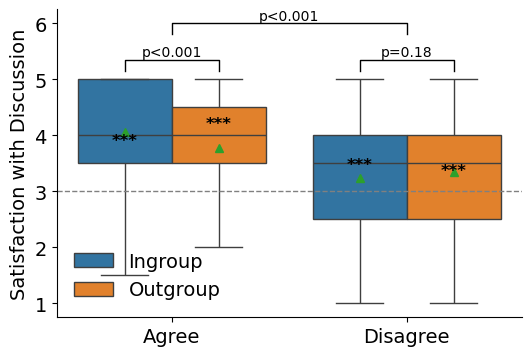

In [ ]:
from scipy.stats import wilcoxon

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x='agree_disagree', y='satis_avg', hue='ingroup_outgroup', showfliers=False, ax=ax, showmeans=True, hue_order=['Ingroup', 'Outgroup'])
ax.set_xlabel('')
ax.set_ylabel('Satisfaction with Discussion')
plt.legend(frameon=False)

# Statistical tests for within-group comparisons
agree_ingroup = df[(df['agree_disagree'] == 'Agree') & (df['ingroup_outgroup'] == 'Ingroup')]['satis_avg']
disagree_ingroup = df[(df['agree_disagree'] == 'Disagree') & (df['ingroup_outgroup'] == 'Ingroup')]['satis_avg']
agree_outgroup = df[(df['agree_disagree'] == 'Agree') & (df['ingroup_outgroup'] == 'Outgroup')]['satis_avg']
disagree_outgroup = df[(df['agree_disagree'] == 'Disagree') & (df['ingroup_outgroup'] == 'Outgroup')]['satis_avg']

# Statistical tests for between-group comparison (all Agree vs all Disagree)
all_agree = df[df['agree_disagree'] == 'Agree']['satis_avg']
all_disagree = df[df['agree_disagree'] == 'Disagree']['satis_avg']

# Mann-Whitney U tests
stat_agree, p_agree = mannwhitneyu(agree_outgroup, agree_ingroup)
stat_disagree, p_disagree = mannwhitneyu(disagree_outgroup, disagree_ingroup)
stat_overall, p_overall = mannwhitneyu(all_agree, all_disagree)

# Test each group against 0 (no change) using Wilcoxon signed-rank test
groups_data = [
    (agree_ingroup, 0.2, 'Agree\nIngroup'),
    (agree_outgroup, -0.2, 'Agree\nOutgroup'),
    (disagree_ingroup, 1.2, 'Disagree\nIngroup'),
    (disagree_outgroup, 0.8, 'Disagree\nOutgroup'),
]

for group_data, x_pos, label in groups_data:
    # Wilcoxon signed-rank test against 0
    stat_wilcox, p_wilcox = wilcoxon(group_data)
    mean_val = group_data.mean()
    
    # Add marker if significantly different from 0
    if p_wilcox < 0.001:
        marker = '***'
    elif p_wilcox < 0.01:
        marker = '**'
    elif p_wilcox < 0.05:
        marker = '*'
    else:
        marker = ''
    
    if marker:
        # Position marker next to the mean point
        ax.text(x_pos, mean_val, marker, ha='center', va='bottom', fontsize=12, fontweight='bold')

# Get the maximum y values for positioning brackets
ymin, y_max = ax.get_ylim()
bracket_height = 0.2

# Add significance brackets
# For Agree group (x=0): Outgroup at x=-0.2, Ingroup at x=0.2
add_significance_bracket(ax, -0.2, 0.2, 5.15, bracket_height, p_agree)

# For Disagree group (x=1): Outgroup at x=0.8, Ingroup at x=1.2  
add_significance_bracket(ax, 0.8, 1.2, 5.15, bracket_height, p_disagree)

# Overall comparison: All Agree vs All Disagree (spanning both groups)
add_significance_bracket(ax, 0, 1, 5.8, bracket_height, p_overall)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axhline(y=3, color='gray', linestyle='--', linewidth=1)

# Add legend
ax.legend(frameon=False, loc='lower left')

fig.savefig('../figures/discussion_quality.pdf', bbox_inches='tight', transparent=True)
fig.savefig('../figures/discussion_quality.png', dpi=300, bbox_inches='tight', transparent=True)
fig.show()

### Bootstrapping

In [28]:
bootstraps = bootstrap_by_agreement_and_group(df = df, column = "satis_avg", N = 1000, sample_size = 500)

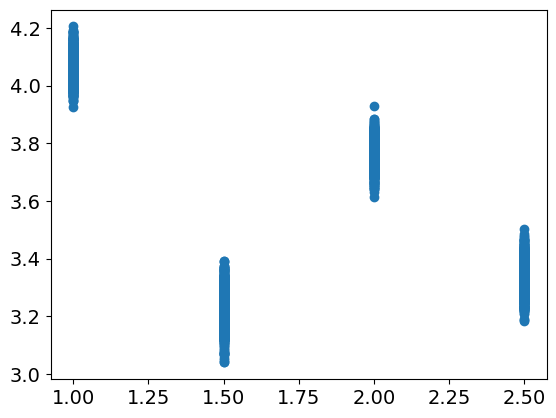

In [37]:
plt.scatter([[1]*1000, [1.5]*1000, [2]*1000, [2.5]*1000], [bootstraps[('Ingroup', 'Agree')], bootstraps[('Ingroup', 'Disagree')], bootstraps[('Outgroup', 'Agree')], bootstraps[('Outgroup', 'Disagree')]])